In [40]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def extract_frames(video_path, output_folder, num_frames=5):
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = [int(i * total_frames / num_frames) for i in range(num_frames)]

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for index in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()

        if ret:
            frame_filename = os.path.join(output_folder, f"frame_{index}.png")
            cv2.imwrite(frame_filename, frame)
            print(f"Frame {index} saved as {frame_filename}")

    cap.release()

In [42]:
video_path = "media1.mp4"

output_folder = "media1_frames"

num_frames = 5

extract_frames(video_path, output_folder, num_frames)

In [43]:
video_path = "media2.mp4"

output_folder = "media2_frames"

num_frames = 5

extract_frames(video_path, output_folder, num_frames)

In [44]:
def show_extracted_frames(images_path):
    image_files = [os.path.join(images_path, file) for file in os.listdir(images_path) if file.endswith(".png")]
    images = [cv2.imread(image) for image in image_files]

    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))

    for i in range(len(images)):
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")

    plt.show()

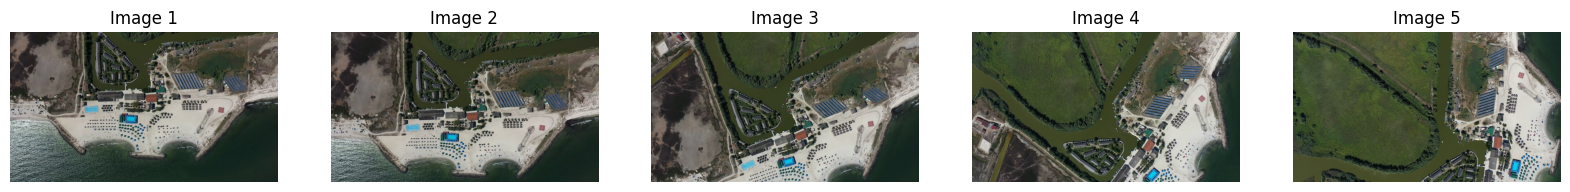

In [45]:
show_extracted_frames("media1_frames")

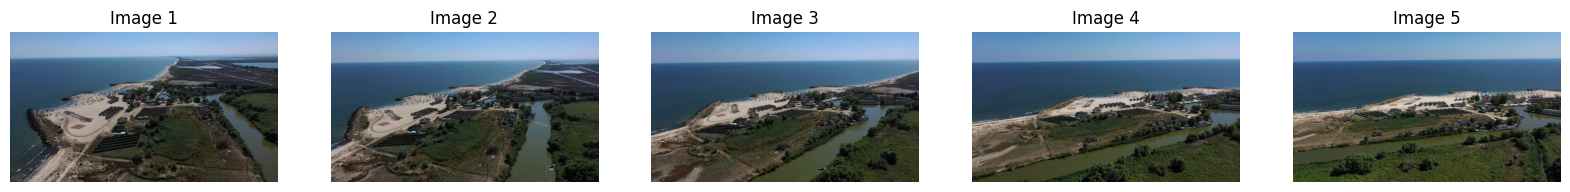

In [58]:
show_extracted_frames("media2_frames")

In [47]:
def get_features(image):
    sift = cv2.SIFT_create()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

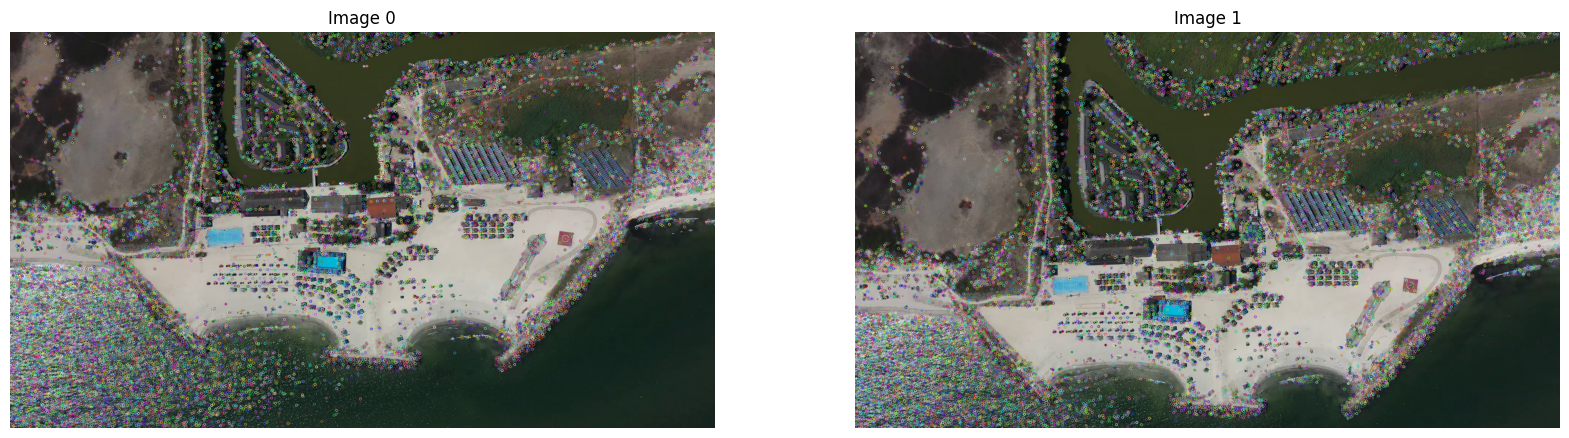

In [48]:
image_files = [os.path.join("media1_frames", file) for file in os.listdir("media1_frames") if file.endswith(".png")]
images = [cv2.imread(image) for image in image_files]

image0 = images[0]
img_keypoints0, img_descriptors0 = get_features(image0)
img_keypoints0 = cv2.drawKeypoints(image0, img_keypoints0, None)

image1 = images[1]
img_keypoints1, img_descriptors1 = get_features(image1)
img_keypoints1 = cv2.drawKeypoints(image1, img_keypoints1, None)

fig, axes = plt.subplots(1, 2, figsize=(20, 12))

axes[0].imshow(cv2.cvtColor(img_keypoints0, cv2.COLOR_BGR2RGB))
axes[0].set_title("Image 0")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img_keypoints1, cv2.COLOR_BGR2RGB))
axes[1].set_title("Image 1")
axes[1].axis('off')

plt.show()


In [49]:
def feature_matching(img_descriptors0, img_descriptors1, num_matches=50):
    index_params = dict(algorithm=0, trees=5)
    search_params = dict(checks=150)     
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.match(img_descriptors0, img_descriptors1)
    matches = sorted(matches, key=lambda x: x.distance)
    best_matches = matches[:num_matches]
    return best_matches


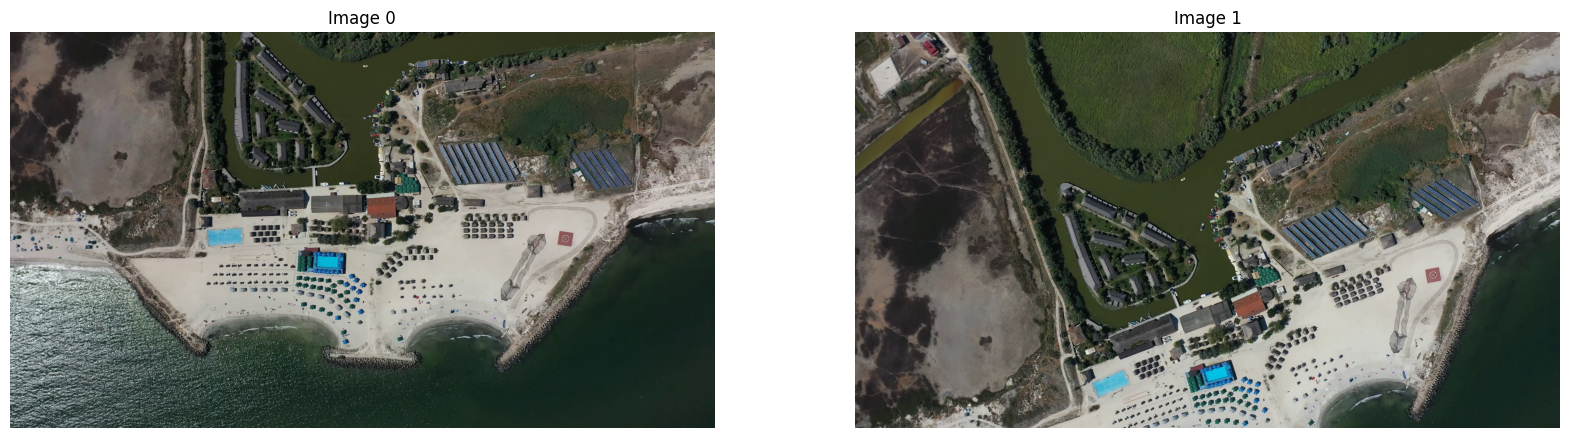

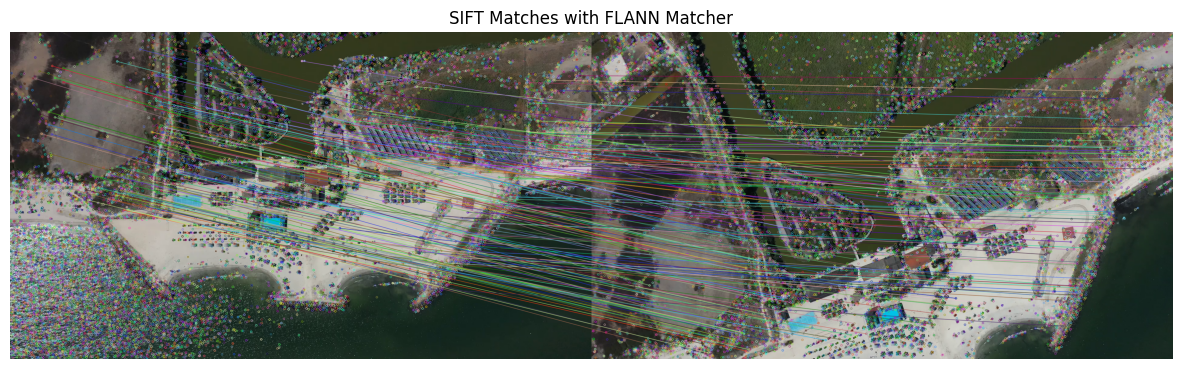

In [50]:
image0 = images[0]
img_keypoints0, img_descriptors0 = get_features(image0)

image1 = images[2]
img_keypoints1, img_descriptors1 = get_features(image1)

matches = feature_matching(img_descriptors0, img_descriptors1, num_matches=200)

match_img = cv2.drawMatches(image0, img_keypoints0, image1, img_keypoints1, matches, None)

fig, axes = plt.subplots(1, 2, figsize=(20, 12))
axes[0].imshow(cv2.cvtColor(image0, cv2.COLOR_BGR2RGB))
axes[0].set_title("Image 0")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
axes[1].set_title("Image 1")
axes[1].axis('off')

plt.figure(figsize=(15, 7))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title("SIFT Matches with FLANN Matcher")
plt.axis('off')
plt.show()



In [51]:
def get_homography_matrix(img_keypoints0, img_keypoints1, matches):
    src_pts = np.float32([img_keypoints0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([img_keypoints1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    homography_matrix, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    return homography_matrix


In [52]:
def warp_image(image1, image2, H):
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]

    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    warped_corners = cv2.perspectiveTransform(corners2, H)


    all_corners = np.concatenate((corners1, warped_corners), axis=0)

    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel())
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel())

    translation = [-xmin, -ymin]
    H_translation = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])

    warped_image = cv2.warpPerspective(image2, H_translation.dot(H), (xmax-xmin, ymax-ymin))
    warped_image[translation[1]:h1+translation[1], translation[0]:w1+translation[0]] = image1

    return warped_image

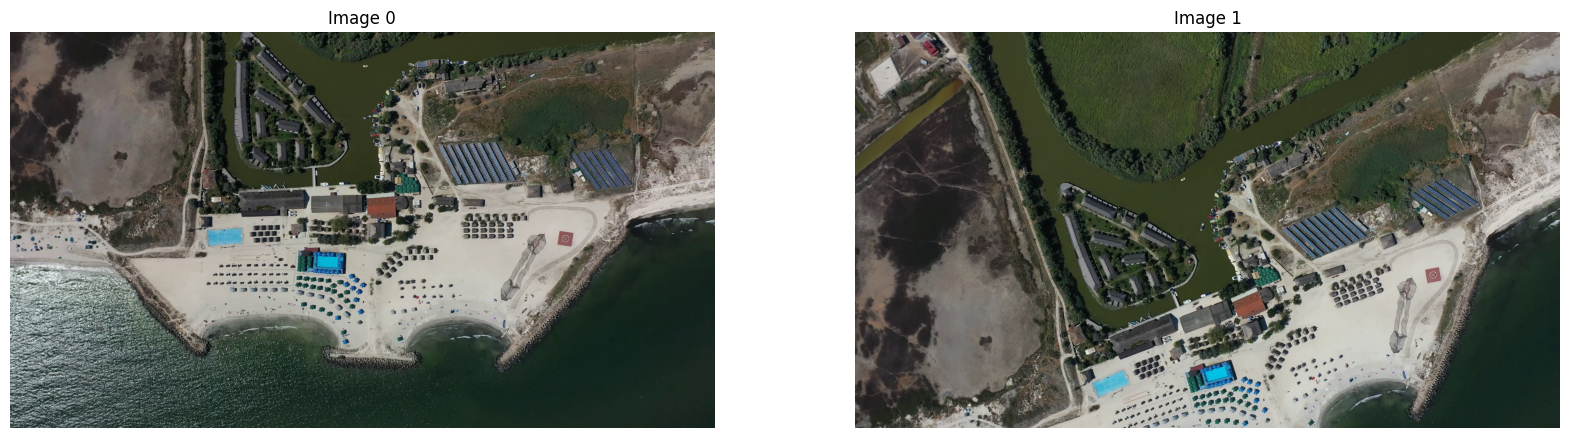

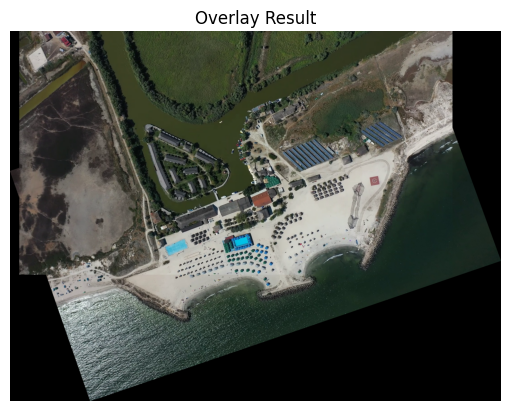

In [53]:
image0 = images[0]
img_keypoints0, img_descriptors0 = get_features(image0)

image1 = images[2]
img_keypoints1, img_descriptors1 = get_features(image1)

matches = feature_matching(img_descriptors0, img_descriptors1, num_matches=200)

homography_matrix = get_homography_matrix(img_keypoints0, img_keypoints1, matches)

result_image = warp_image(image1, image0, homography_matrix)


fig, axes = plt.subplots(1, 2, figsize=(20, 12))
axes[0].imshow(cv2.cvtColor(image0, cv2.COLOR_BGR2RGB))
axes[0].set_title("Image 0")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
axes[1].set_title("Image 1")
axes[1].axis('off')
plt.show()

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title("Overlay Result")
plt.axis('off')
plt.show()

In [54]:
def create_panorama(images):
    panorama = images[0].copy()

    for i in range(1, len(images)):
        keypoints1, descriptors1 = get_features(panorama)
        keypoints2, descriptors2 = get_features(images[i])

        matches = feature_matching(descriptors1, descriptors2)

        homography_matrix = get_homography_matrix(keypoints1, keypoints2, matches)

        panorama = warp_image(images[i], panorama, homography_matrix)

    return panorama

In [55]:
def remove_black_border(panorama_image):
    gray = cv2.cvtColor(panorama_image, cv2.COLOR_BGR2GRAY)

    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])

        cropped_panorama = panorama_image[y:y+h, x:x+w]

        return cropped_panorama
    else:
        return panorama_image

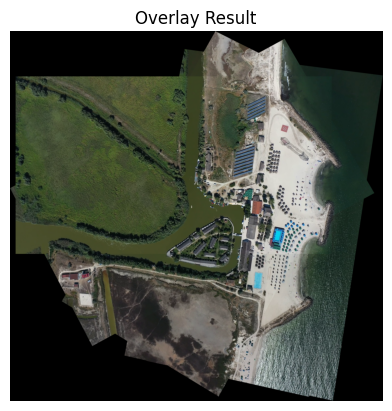

In [56]:
image_files = [os.path.join("media1_frames", file) for file in os.listdir("media1_frames") if file.endswith(".png")]
images1 = [cv2.imread(image) for image in image_files]

panorama_image1 = create_panorama(images1)
cropped_panorama1 = remove_black_border(panorama_image1)

cv2.imwrite('above_panorama.jpg', cropped_panorama1)

plt.imshow(cv2.cvtColor(cropped_panorama1, cv2.COLOR_BGR2RGB))
plt.title("Overlay Result")
plt.axis('off')
plt.show()

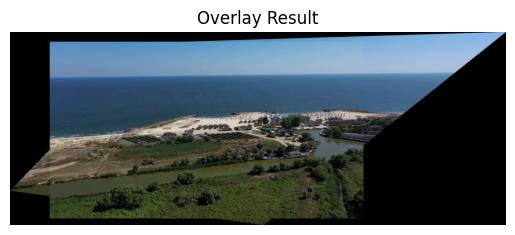

In [60]:
image_files = [os.path.join("media2_frames", file) for file in os.listdir("media2_frames") if file.endswith(".png")]
images2 = [cv2.imread(image) for image in image_files]

panorama_image2 = create_panorama(images2)
cropped_panorama2 = remove_black_border(panorama_image2)

cv2.imwrite('angle_panorama.jpg', cropped_panorama2)

plt.imshow(cv2.cvtColor(cropped_panorama2, cv2.COLOR_BGR2RGB))
plt.title("Overlay Result")
plt.axis('off')
plt.show()